In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


In [ ]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Function to load images from a directory
def load_images_from_dir(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label)
    return images, labels

In [16]:
# Load images from directories
benign_dir = "/content/drive/MyDrive/ML/archive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/drive/MyDrive/ML/archive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
normal_dir = "/content/drive/MyDrive/ML/archive/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases"

In [17]:
benign_images, benign_labels = load_images_from_dir(benign_dir, label=0)  # Assign label 0 for benign cases
malignant_images, malignant_labels = load_images_from_dir(malignant_dir, label=1)  # Assign label 1 for malignant cases
normal_images, normal_labels = load_images_from_dir(normal_dir, label=2)  # Assign label 2 for normal cases


In [18]:
print(f"Loaded {len(benign_images)} benign images.")
print(f"Loaded {len(malignant_images)} malignant images.")
print(f"Loaded {len(normal_images)} normal images.")


Loaded 120 benign images.
Loaded 561 malignant images.
Loaded 416 normal images.


In [19]:
# Combine all images and labels
images = benign_images + malignant_images + normal_images
labels = benign_labels + malignant_labels + normal_labels

In [20]:
num_images = len(images)
num_labels = len(labels)

print(f"Number of images: {num_images}")
print(f"Number of labels: {num_labels}")

Number of images: 1097
Number of labels: 1097


In [21]:
# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [22]:
# Print class distribution before oversampling
print("Class distribution before oversampling:", Counter(labels))

Class distribution before oversampling: Counter({np.int64(1): 561, np.int64(2): 416, np.int64(0): 120})


In [23]:
import pandas as pd
import plotly.express as px

# Create a DataFrame with the counts of each category
count_data = pd.DataFrame({
    "label": ["Benign", "Malignant", "Normal"],
    "count": [len(benign_images), len(malignant_images), len(normal_images)]
})

# Create histogram using Plotly Express
fig = px.histogram(data_frame=count_data, x="label", y="count", color="label")

# Show the histogram
fig.show()

In [25]:
# Reshape images for oversampling
images_reshaped = images.reshape(len(images), -1)  # Flatten images for oversampling

In [26]:
# Apply Random Oversampling
oversampler = RandomOverSampler(random_state=42)
images_resampled, labels_resampled = oversampler.fit_resample(images_reshaped, labels)

In [27]:
# Reshape images back to original shape
images_resampled = images_resampled.reshape(-1, 128, 128)

In [28]:
num_images = len(images_resampled)
num_labels = len(labels_resampled)

print(f"Number of images: {num_images}")
print(f"Number of labels: {num_labels}")

Number of images: 1683
Number of labels: 1683


In [29]:
# Print class distribution after oversampling
print("Class distribution after oversampling:", Counter(labels_resampled))

Class distribution after oversampling: Counter({np.int64(0): 561, np.int64(1): 561, np.int64(2): 561})


In [30]:
import pandas as pd
import plotly.express as px

# Create a DataFrame with the counts of each category after oversampling
count_data_resampled = pd.DataFrame({
    "label": ["Benign", "Malignant", "Normal"],
    "count": [np.sum(labels_resampled == 0), np.sum(labels_resampled == 1), np.sum(labels_resampled == 2)]
})

# Create histogram using Plotly Express
fig = px.histogram(data_frame=count_data_resampled, x="label", y="count", color="label")
fig.show()

In [31]:
# Normalize pixel values to [0, 1]
images_resampled = images_resampled / 255.0

In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_resampled, labels_resampled, test_size=0.2, random_state=42)

In [33]:
# Print the number of training and testing images
print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of testing images: {X_test.shape[0]}")

Number of training images: 1346
Number of testing images: 337


In [34]:
# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)


In [37]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes: benign, malignant, normal
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Reshape X_train for training
X_train = X_train.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

In [39]:
# Train the model
history = model.fit(
    X_train, y_train_encoded,
    epochs=10,  # Train for more epochs
    batch_size=32,
    validation_data=(X_test, y_test_encoded)
)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4157 - loss: 1.1413 - val_accuracy: 0.6884 - val_loss: 0.7854
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6806 - loss: 0.7029 - val_accuracy: 0.9169 - val_loss: 0.2611
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8884 - loss: 0.2857 - val_accuracy: 0.9496 - val_loss: 0.1460
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9616 - loss: 0.1090 - val_accuracy: 0.9822 - val_loss: 0.0523
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9625 - loss: 0.1298 - val_accuracy: 0.9852 - val_loss: 0.0463
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9834 - loss: 0.0521 - val_accuracy: 0.9852 - val_loss: 0.0355
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9908 - loss: 0.0301 - val_accuracy: 0.9911 - val_loss: 0.0275
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9988 - loss: 0.0125 - val_accuracy: 0.9911 - val_loss:

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Plot training history
def history_plot(history):
    epochs = len(history.history['accuracy'])
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["accuracy"], name="Training Accuracy"))
    fig1.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["val_accuracy"], name="Validation Accuracy"))
    fig1.update_layout(title="Training and Validation Accuracy", xaxis_title="Epoch", yaxis_title="Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["loss"], name="Training Loss"))
    fig2.add_trace(go.Scatter(x=np.arange(1, epochs + 1), y=history.history["val_loss"], name="Validation Loss"))
    fig2.update_layout(title="Training and Validation Loss", xaxis_title="Epoch", yaxis_title="Loss")
    fig2.show()

history_plot(history)

In [41]:
# Evaluate the model
y_pred = model.predict(X_test.reshape(-1, 128, 128, 1))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Benign', 'Malignant', 'Normal'])
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99       106
   Malignant       1.00      0.98      0.99       125
      Normal       0.99      0.99      0.99       106

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337



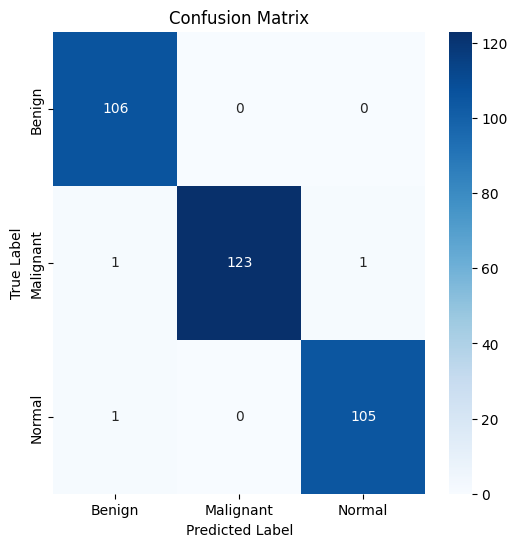

In [42]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step


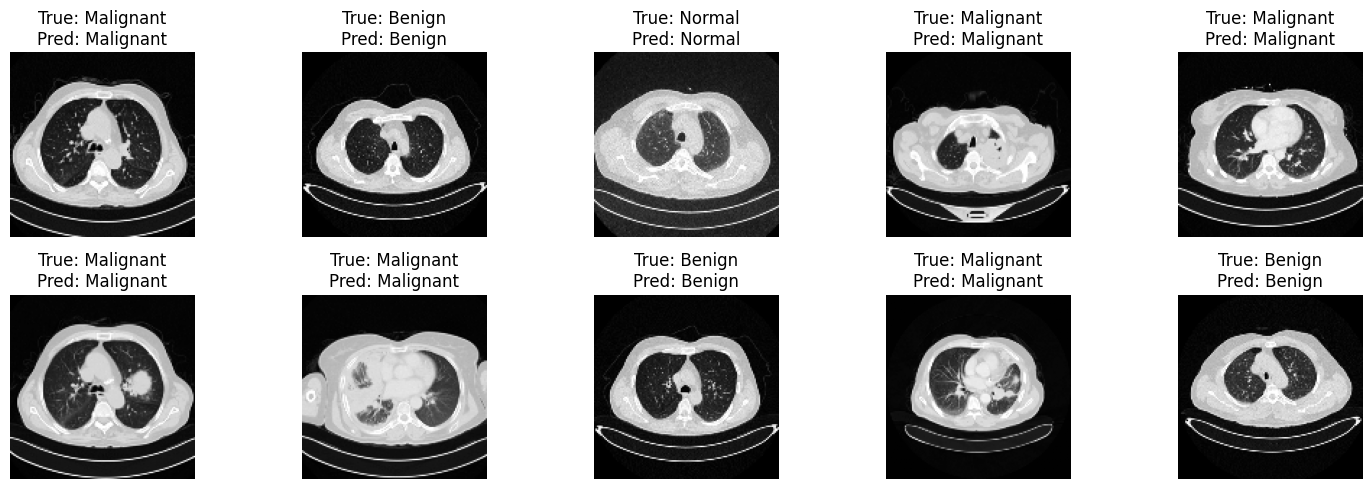

In [43]:
import random
import matplotlib.pyplot as plt

def show_correctly_classified_images(X_test, y_true_classes, y_pred_classes, class_names, num_images=10):
    """
    Display a random selection of correctly classified images.

    Parameters:
        X_test (numpy array): Test images.
        y_true_classes (numpy array): True labels.
        y_pred_classes (numpy array): Predicted labels.
        class_names (list): List of class names (e.g., ['Benign', 'Malignant', 'Normal']).
        num_images (int): Number of images to display.
    """
    # Find indices of correctly classified images
    correct_indices = np.where(y_true_classes == y_pred_classes)[0]

    if len(correct_indices) == 0:
        print("No correctly classified images found.")
        return

    # Randomly select a subset of correctly classified images
    random.shuffle(correct_indices)
    selected_indices = correct_indices[:num_images]

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(128, 128), cmap="gray")
        true_label = class_names[y_true_classes[idx]]
        pred_label = class_names[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Class names
class_names = ['Benign', 'Malignant', 'Normal']

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Display correctly classified images
show_correctly_classified_images(X_test, y_true_classes, y_pred_classes, class_names, num_images=10)